* This notebook aims at analyzing the content of an E-commerce database that lists purchases made by  ∼ 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.

* Customer segmentation is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors, including: demographics (age, gender, location etc), behaviour (previous orders, responses to messaging), psychographics (values, interests, lifestyles) etc.

* RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

* The goal of this analysis is to identify customer segments for global retail company using RFM analysis and to understand how those groups differ from each other.

# Data Preperation 

### Step 1: Import libraries

In [1]:
import pandas as pd
import numpy as np 
import time
import datetime as dt

import re

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score




import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

start = time.time()

In [222]:
df = pd.read_csv('C:\\Users\\Drumil\\resume\\OnlineRetail.csv', encoding='cp1252')

# The first five rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [223]:
# The last five rows 

df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


# Data Explorations:

### Columns Description

* InvoiceNo : Unique ID for every time a consumer visits the store
* StockCode: Unique ID for a product
* Description : Description of the product
* Quantity : No of units bought
* InvoiceDate : Date and time of purchase
* Unit Price : Price for 1 unit of the product
* CustomerId : Unique ID for each customer
* Country : Country where transaction happened

In [224]:
# I will change the names or the first letters of some columns in order to make it easy as i type

df.rename(index = str , 
          columns = {'InvoiceNo': 'invoice_num',
                    'StockCode' : 'stock_code',
                    'Description' : 'description',
                    'Quantity' : 'quantity',
                    'InvoiceDate' : 'invoice_date',
                    'UnitPrice' : 'unit_price',
                    'CustomerID' : 'customer_id',
                    'Country' : 'country'}, inplace=True)

In [225]:
# The data has 541909 entries and 8 variables before we make any adjustment
# After loading data set, we are trying to get general information about our dataset.

print('The shape of our dataset before we make any adjustment is', df.shape)

The shape of our dataset before we make any adjustment is (541909, 8)


In [226]:
print('Some info about our dataset is below: \n')

df.info()

Some info about our dataset is below: 

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_num   541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [227]:
print('Here are info about the type of each column: \n')

df.dtypes

Here are info about the type of each column: 



invoice_num      object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

# Step 2: Data Cleaning 

### Dealing with the missing data

In [228]:
# As we can see we have a lot of missing data in this dataset
# However some of them is not really important, so we don't have problem so far

print('Here we can view the missing data in our dataset: \n')

df.isnull().sum()

Here we can view the missing data in our dataset: 



invoice_num          0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [229]:
print('Here we can view the percentage of the missing data in our dataset: \n')

missing_percentage = (( df.isnull().sum() / df.shape[0] ) * 100).round(2)
missing_percentage

Here we can view the percentage of the missing data in our dataset: 



invoice_num      0.00
stock_code       0.00
description      0.27
quantity         0.00
invoice_date     0.00
unit_price       0.00
customer_id     24.93
country          0.00
dtype: float64

* As we can see above almost the 26% of the customers are unknown!
* Moreover, we have 1.1% of the other columns missing
* We have to dig deaper in order to understand more our dataset

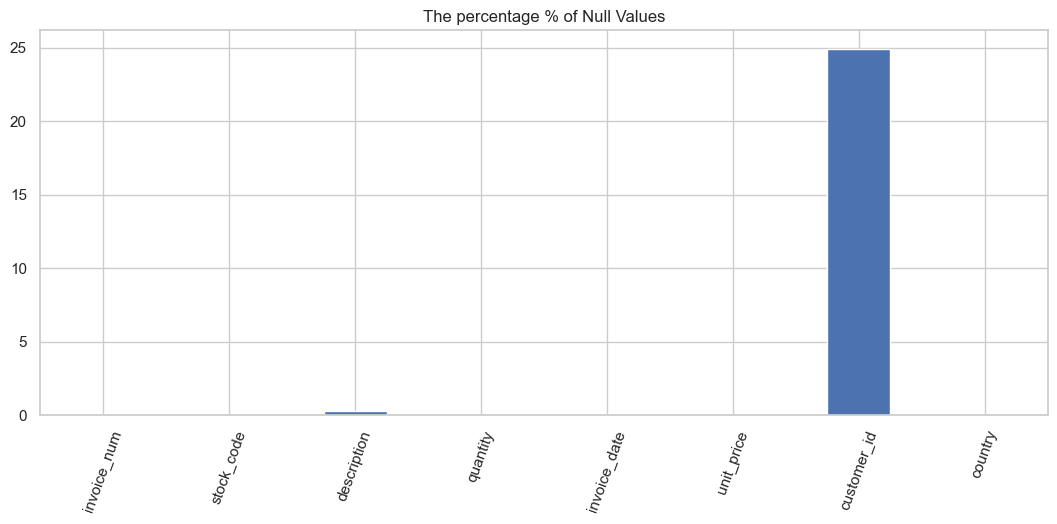

In [230]:
fig,ax = plt.subplots( figsize=(13,5))
((df.isnull().sum() / len(df))*100).plot.bar(ax=ax,rot= 70)
ax.set_title('The percentage % of Null Values')
plt.show()

In [231]:
# Droping rows having missing values

df.dropna(inplace=True)

print('Missing Values after the cleaning: {}'.format(df.isnull().sum().sum()))

Missing Values after the cleaning: 0


In [232]:
#Double check it, just in case

df.isnull().sum()

invoice_num     0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### Checking for duplicate rows 

In [233]:
duplicates_rows = df[df.duplicated()].value_counts().sum()
print('The total amount of duplicates rows are' , duplicates_rows)

The total amount of duplicates rows are 5225


In [234]:
# View the duplicate rows 
# For example, the rows 598, 601, 604 are the same as we can se notice

df[df.duplicated()].head(20)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
587,536412,22273,FELTCRAFT DOLL MOLLY,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
589,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,12/1/2010 11:49,3.75,17920.0,United Kingdom
594,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1,12/1/2010 11:49,2.10,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
600,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2,12/1/2010 11:49,3.75,17920.0,United Kingdom


In [235]:
# Deal with the duplicates in this kernel 
# If you check the first shape we had many duplicates 
# First we had 541909 and now 398003

df.drop_duplicates(inplace = True, keep = 'first')
df.shape

(401604, 8)

In [236]:
duplicate_rows_new = df[df.duplicated()].value_counts().sum()
print('The total amount of duplicates rows after the cleaning are' , duplicate_rows_new)

The total amount of duplicates rows after the cleaning are 0


# Step 3: Time

In [237]:
# Change the format of the invoice_date 

df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_date'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: invoice_date, dtype: datetime64[ns]

In [238]:
print("The datafile starts with timepoint {} \n".format(df['invoice_date'].min()))


print("The datafile ends with timepoint {}".format((df['invoice_date'].max())))

The datafile starts with timepoint 2010-12-01 08:26:00 

The datafile ends with timepoint 2011-12-09 12:50:00


In [239]:
last_date = df['invoice_date'].min()
present_date = df['invoice_date'].max()
print('The most present date is', present_date)

The most present date is 2011-12-09 12:50:00


In [240]:
# Because of the dt.strftime and the to_datetime the type of the invoice_date changed twiced and here i make sure it's the right one

df.dtypes

invoice_num             object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

# Explore the data 

* After we cleaned the dataset we must dig deeper into this 

### Countries

In [241]:
# If you are worry about the last country, it's just the Republic of South Africa (RSA) and EIRE is just the Republic of Ireland

print('Below are the unique name of the countries: \n')

df['country'].value_counts().reset_index()

Below are the unique name of the countries: 



,index,country
0,United Kingdom,356728
1,Germany,9480
2,France,8475
3,EIRE,7475
4,Spain,2528
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,1877
8,Portugal,1471
9,Australia,1258


In [242]:
print('In general the total numbers of the countries are:' , len(df['country'].unique()))

In general the total numbers of the countries are: 37


In [243]:
# How many customers per country 

country_df = df[['country' , 'customer_id']]
country_df.groupby(['country']).agg({'customer_id' : 'count'}).sort_values('customer_id', ascending = False).reset_index()

,country,customer_id
0,United Kingdom,356728
1,Germany,9480
2,France,8475
3,EIRE,7475
4,Spain,2528
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,1877
8,Portugal,1471
9,Australia,1258


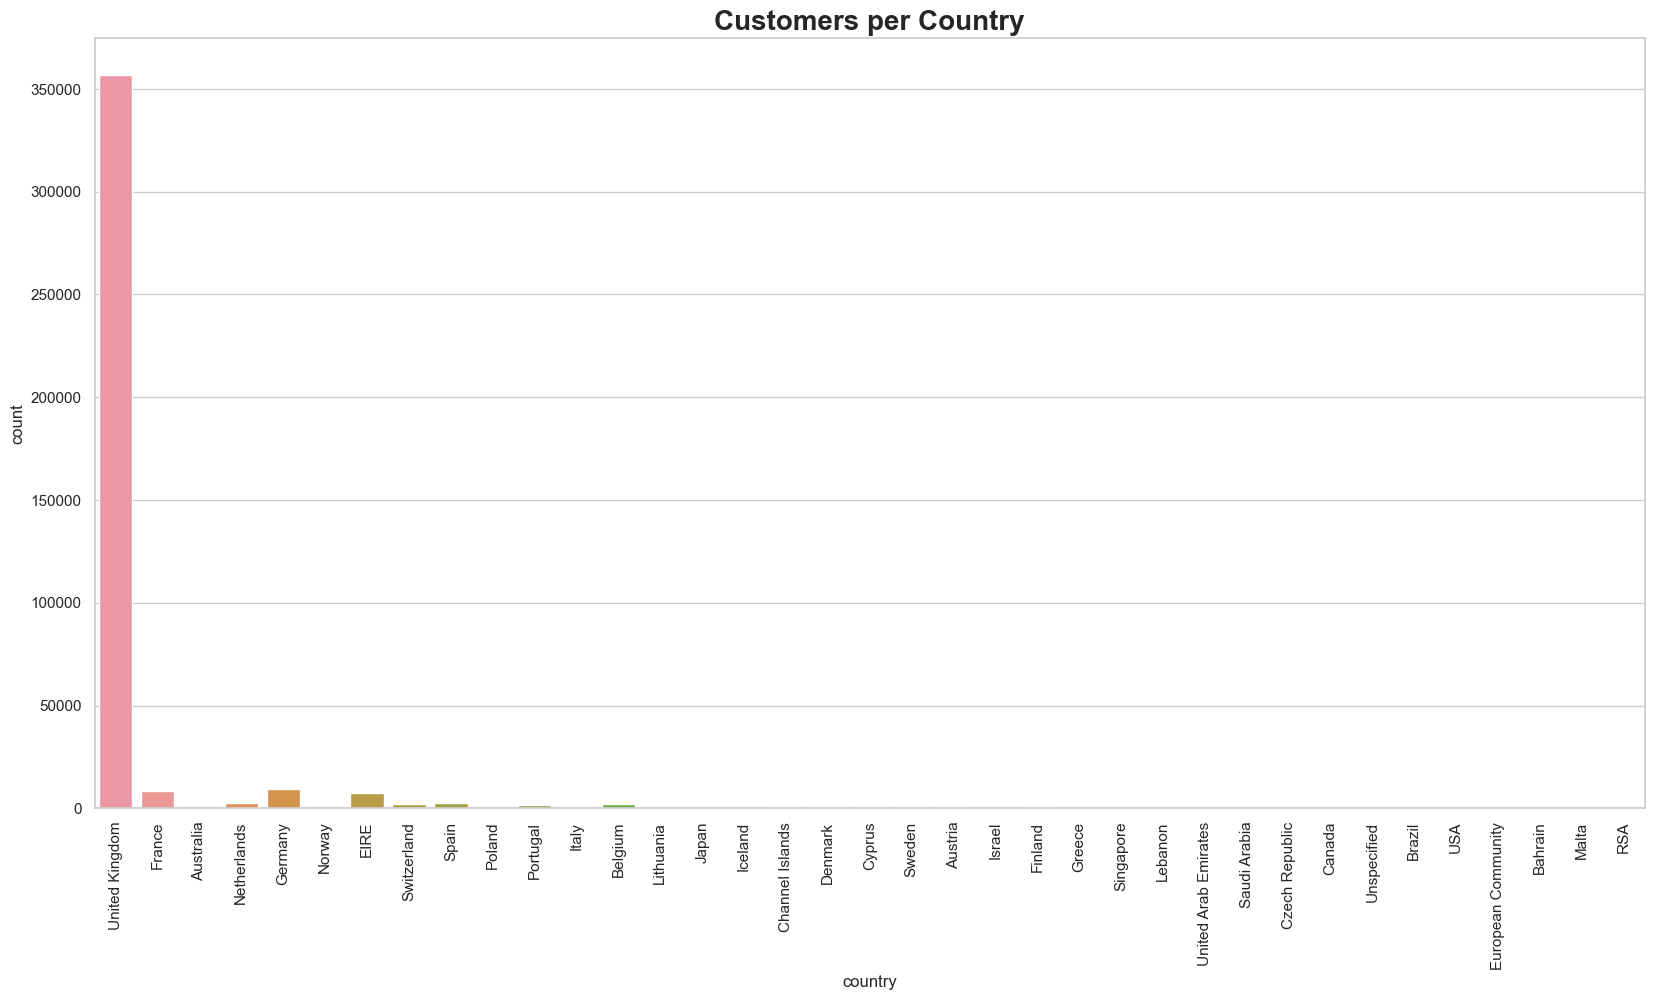

In [244]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig = plt.subplots(figsize=(20, 10))

#plot count of each RFM segment
sns.countplot(x="country", data=country_df).set_title('Customers per Country', weight = 'bold').set_fontsize('20')
plt.xticks(rotation=90)

plt.show()

In [245]:
# Now we will look at the details of the countries through which most of the orders were placed

df[['invoice_num','country']].groupby('country').count().sort_values("invoice_num",ascending = False).reset_index()

,country,invoice_num
0,United Kingdom,356728
1,Germany,9480
2,France,8475
3,EIRE,7475
4,Spain,2528
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,1877
8,Portugal,1471
9,Australia,1258


In [246]:
df.describe().round(2)

,quantity,unit_price,customer_id
count,401604.00,401604.00,401604.00
mean,12.18,3.47,15281.16
std,250.28,69.76,1714.01
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13939.00
50%,5.00,1.95,15145.00
75%,12.00,3.75,16784.00
max,80995.00,38970.00,18287.00


In [247]:
# How many of each product are there?

df['stock_code'].value_counts().head(10)

85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
20725     1346
22720     1224
POST      1196
22197     1110
23203     1108
Name: stock_code, dtype: int64

In [248]:
# But what kinf of products are these ? 

print('Below are the top five items we have: \n')

most_stock_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=False)
most_stock_item.head(10)

Below are the top five items we have: 



stock_code  description                       
85123A      WHITE HANGING HEART T-LIGHT HOLDER    2058
22423       REGENCY CAKESTAND 3 TIER              1894
85099B      JUMBO BAG RED RETROSPOT               1659
47566       PARTY BUNTING                         1409
84879       ASSORTED COLOUR BIRD ORNAMENT         1405
20725       LUNCH BAG RED RETROSPOT               1345
22720       SET OF 3 CAKE TINS PANTRY DESIGN      1224
POST        POSTAGE                               1196
20727       LUNCH BAG  BLACK SKULL.               1099
21212       PACK OF 72 RETROSPOT CAKE CASES       1062
Name: description, dtype: int64

### Stock code 

In [249]:
# View all the stock code of the dataset 

list_special_codes = df[df['stock_code'].str.contains('^[a-zA-Z]+', regex=True)]['stock_code'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [250]:
for code in list_special_codes:
    print("{:<15} ->  {:<30}".format(code, df[df['stock_code'] == code]['description'].unique()[0]))

POST            ->  POSTAGE                       
D               ->  Discount                      
C2              ->  CARRIAGE                      
M               ->  Manual                        
BANK CHARGES    ->  Bank Charges                  
PADS            ->  PADS TO MATCH ALL CUSHIONS    
DOT             ->  DOTCOM POSTAGE                
CRUK            ->  CRUK Commission               


### Cancelled Orders & Quantity

In [251]:
# The number of canceled orders 
# In the data description we can find that a cancelled transactions starts with a "C" in front of it. 
# Let's create a feature to easily filter out these cases:

canceled = (df["invoice_num"].str.contains("C", na=False)).sum()

print('The total number of items that was canceled are', canceled)

The total number of items that was canceled are 8872


In [252]:
per_canceled = ((canceled / df.shape[0]) * 100 ).round(2)

print('The percentage of canceled orders is ',per_canceled , '%')

The percentage of canceled orders is  2.21 %


In [253]:
# I am checking if there is negative quantity in tha data 
# Unluckily we have at least one 

flag = False
if (df['quantity'] < 0).any(): 
    flag = True
    print(flag)

True


In [254]:
df['canceled'] = df['invoice_num'].apply(lambda x : 'Yes' if x[0] == 'C' else 'No')

In [255]:
# There is negative quantity in the dataset. Let's check it
# Obviously there are negative quantity 

negative_quantity = df[df['quantity'] < 0]
negative_quantity.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,canceled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,Yes
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,Yes
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,Yes
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,Yes
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,Yes


In [256]:
print('The total number of items that was canceled are',negative_quantity.value_counts().sum() ) 

The total number of items that was canceled are 8872


In [257]:
# The shape of our dataset just got even smaller after the drop 

df.shape

(401604, 9)

# Calculation of RFM metrics

* Recency : the number of days between today_date and the last purchase date of this customer

* Frequency : the number of purchase of this customer

* Monetary : sum of TotalPrice of this customer

In [258]:
# I create a new column here 

df["total_price"] = df["quantity"] * df["unit_price"]

In [259]:
df.sort_values('total_price', ascending=False).head().reset_index()

,index,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,canceled,total_price
0,540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,No,168469.60
1,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,No,77183.60
2,222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,No,38970.00
3,173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,No,8142.75
4,348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,No,7144.72


In [260]:
today_date = dt.datetime(2011,12,11)

In [261]:
present = dt.date(2011,12,9)

#### Create the RFM Table

In [262]:
rfm = df.groupby('customer_id').agg({'invoice_date' : lambda invoice_date:  (today_date - invoice_date.max()).days,
                                    'invoice_num'   : lambda invoice_num:   invoice_num.nunique(),
                                    'total_price'   : lambda total_price:   total_price.sum()})

In [263]:
rfm.shape

(4372, 3)

In [264]:
rfm.columns = ['recency','frequency','monetary']
rfm = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()
rfm.head()

,customer_id,recency,frequency,monetary
0,12347.0,3,7,4310.00
1,12348.0,76,4,1797.24
2,12349.0,19,1,1757.55
3,12350.0,311,1,334.40
4,12352.0,37,11,1545.41


In [265]:
rfm.sample()

,customer_id,recency,frequency,monetary
2126,15254.0,128,1,300.36


In [266]:
rfm['customer_id'] = rfm['customer_id'].astype('object')


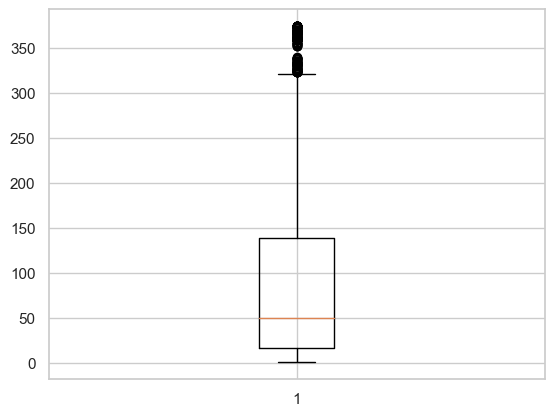

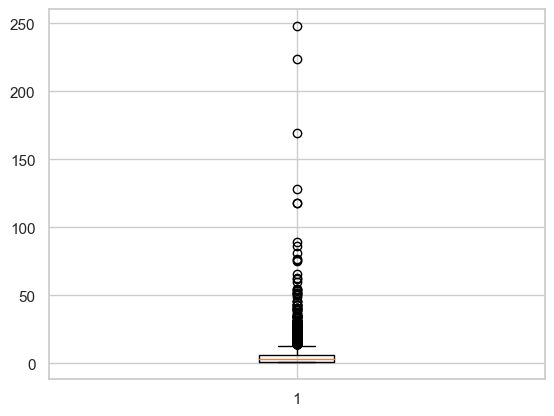

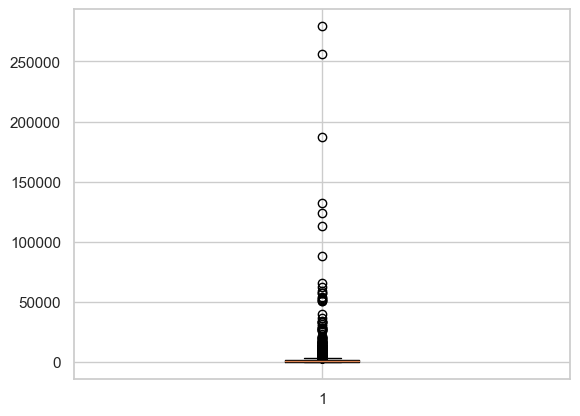

In [267]:
# set sns theme
# sns.set_theme(style="whitegrid")

#set plot size
# fig, ax = plt.subplots(figsize=(13, 7))

plt.boxplot(rfm['recency'])
plt.show()

plt.boxplot(rfm['frequency'])
plt.show()

plt.boxplot(rfm['monetary'])

plt.show()
# rfm['recency'].boxplot(grid=False, rot=45, fontsize=15)

In [268]:
# Fing top 10 customers based on frequency and monetary values
# Sorting first on frequency and then on Monetary value¶
# Below are top ten customers after sorting¶

rfm.sort_values(['frequency', 'monetary'], ascending=[False, False], inplace=True)
rfm.head()

,customer_id,recency,frequency,monetary
1871,14911.0,2,248,132458.73
323,12748.0,1,224,28405.56
3994,17841.0,2,169,39869.05
1654,14606.0,2,128,11633.35
2168,15311.0,1,118,59284.19


In [269]:
rfm_new = rfm.copy()

In [272]:
# i use the method qcut, in order to cut the three columns in five quartiles. 
# I could do it by hand by i didn't really like especially pandas has it arleady 

rfm['recency_score'] = pd.qcut(rfm['recency'] , 5 , labels = range(5,0,-1))

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels =range(1, 6, 1) )

rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels= range(1, 6, 1))

rfm['RFM_Score'] = rfm[['recency_score', 'frequency_score', 'monetary_score']].sum(axis=1).astype(int)

rfm['RFM_Segmentantion'] = (rfm['recency_score'].astype(str) 
                            + rfm['frequency_score'].astype(str) 
                            + rfm['monetary_score'].astype(str))

In [273]:
rfm.sample(20)

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segmentantion
3641,17356.0,312,1,178.22,1,1,1,3,111
147,12532.0,31,1,349.83,4,1,2,7,412
431,12906.0,12,5,2919.81,5,4,5,14,545
85,12451.0,11,6,8933.52,5,4,5,14,545
3266,16813.0,9,10,1652.18,5,5,4,14,554
2822,16204.0,24,1,384.18,4,1,2,7,412
2899,16318.0,36,1,328.15,3,1,2,6,312
2033,15132.0,19,5,977.93,4,4,4,12,444
2893,16309.0,92,3,686.67,2,3,3,8,233
541,13062.0,192,1,346.98,1,1,2,4,112


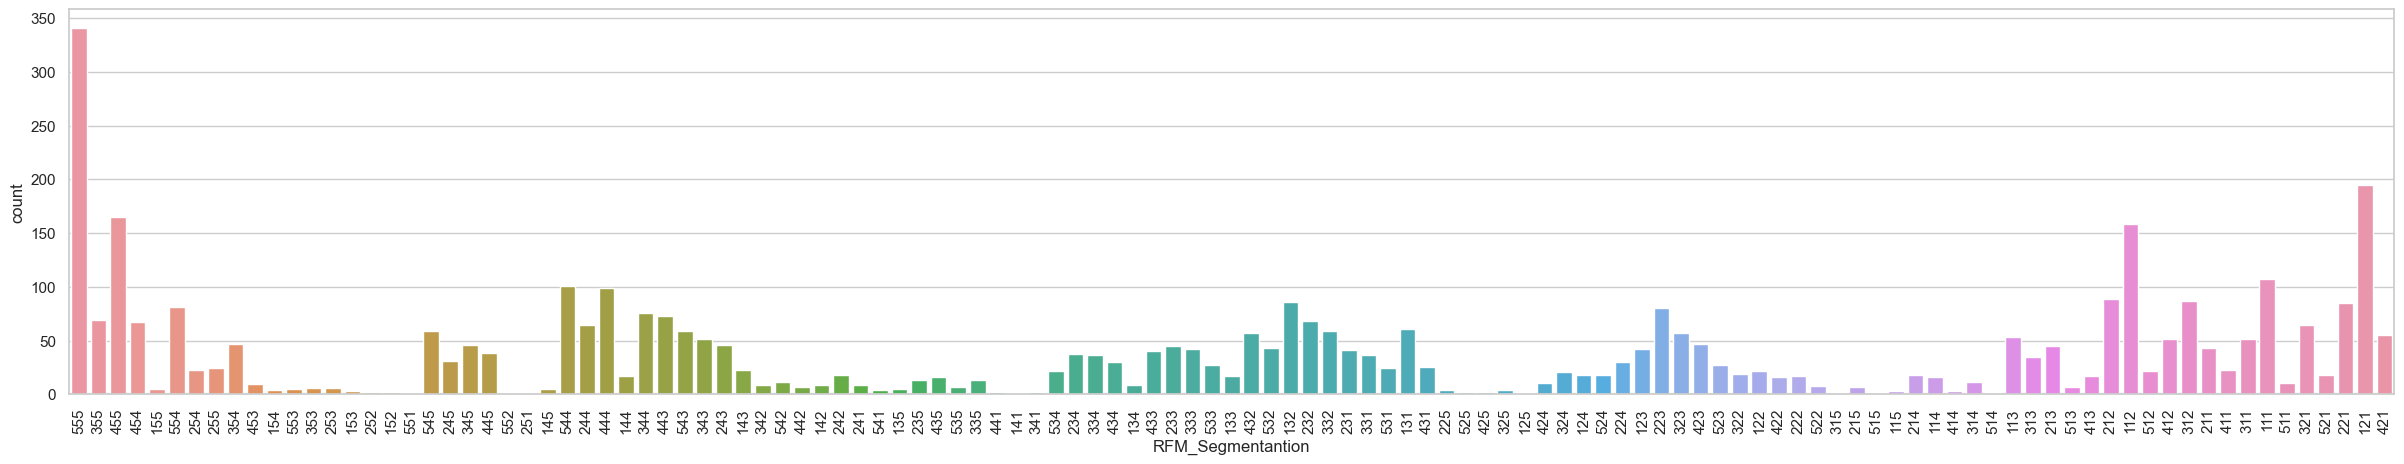

In [274]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(30, 5))

#plot count of each RFM segment
sns.countplot(x="RFM_Segmentantion", data=rfm)
plt.xticks(rotation=90)

plt.show()

In [309]:
# Create a new column accordingly to the customers score 

def rank(a):
    
    if  (a >= 0) & (a <= 4):
        return '0'
    
    elif (a <=10):
        return '1'
    
    else :
        return '2'
    

In [310]:
rfm['Rank_id'] = rfm['RFM_Score'].apply(rank)
rfm.head(10).reset_index()

,index,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segmentantion,Rank_id
0,1871,14911.0,2,248,132458.73,5,5,5,15,555,2
1,323,12748.0,1,224,28405.56,5,5,5,15,555,2
2,3994,17841.0,2,169,39869.05,5,5,5,15,555,2
3,1654,14606.0,2,128,11633.35,5,5,5,15,555,2
4,2168,15311.0,1,118,59284.19,5,5,5,15,555,2
5,559,13089.0,3,118,57322.13,5,5,5,15,555,2
6,478,12971.0,4,89,10930.26,5,5,5,15,555,2
7,1596,14527.0,3,86,7709.69,5,5,5,15,555,2
8,792,13408.0,2,81,27487.41,5,5,5,15,555,2
9,1682,14646.0,2,77,279489.02,5,5,5,15,555,2


In [311]:
rfm.tail()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segmentantion,Rank_id
2734,16093.0,107,1,17.00,2,2,1,5,221,1
719,13307.0,121,1,15.00,2,2,1,5,221,1
3944,17763.0,264,1,15.00,1,2,1,4,121,0
4082,17956.0,250,1,12.75,1,2,1,4,121,0
3205,16738.0,298,1,3.75,1,2,1,4,121,0


In [312]:
silhouette_avg = silhouette_score(rfm[['RFM_Score']], rfm['Rank_id'])

In [313]:
silhouette_avg

0.4999789560195401

In [314]:
rfm[rfm['Rank_id']=='Basic'].count()

customer_id          0
recency              0
frequency            0
monetary             0
recency_score        0
frequency_score      0
monetary_score       0
RFM_Score            0
RFM_Segmentantion    0
Rank_id              0
dtype: int64

In [315]:
# We can underastand better the clients by the rank 

ranks = rfm['Rank_id'].value_counts()
ranks

1    2237
2    1579
0     504
Name: Rank_id, dtype: int64

In [280]:
rfm_new = rfm_new.drop(['customer_id'], axis = 1)
rfm_new.head()

,recency,frequency,monetary
1871,2,248,132458.73
323,1,224,28405.56
3994,2,169,39869.05
1654,2,128,11633.35
2168,1,118,59284.19


In [281]:
rfm_new.dropna(inplace = True)
rfm_new.isnull().sum()

recency      0
frequency    0
monetary     0
dtype: int64

In [282]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_new)

C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [283]:
# rfm_new['Cluster_Id'] = kmeans.labels_
# rfm_new['Cluster_Id'].value_counts()

In [284]:
rfm_new

,recency,frequency,monetary
1871,2,248,132458.73
323,1,224,28405.56
3994,2,169,39869.05
1654,2,128,11633.35
2168,1,118,59284.19
...,...,...,...
2734,107,1,17.00
719,121,1,15.00
3944,264,1,15.00
4082,250,1,12.75


In [285]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data and transform it
rfm_new1 = scaler.fit_transform(rfm_new)

In [286]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_new1)

C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [287]:
rfm_new['Cluster_Id'] = kmeans.labels_
rfm_new['Cluster_Id'].value_counts()

1    3219
0    1078
2      23
Name: Cluster_Id, dtype: int64

In [288]:
rfm_new

,recency,frequency,monetary,Cluster_Id
1871,2,248,132458.73,2
323,1,224,28405.56,2
3994,2,169,39869.05,2
1654,2,128,11633.35,2
2168,1,118,59284.19,2
...,...,...,...,...
2734,107,1,17.00,1
719,121,1,15.00,1
3944,264,1,15.00,0
4082,250,1,12.75,0


C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\

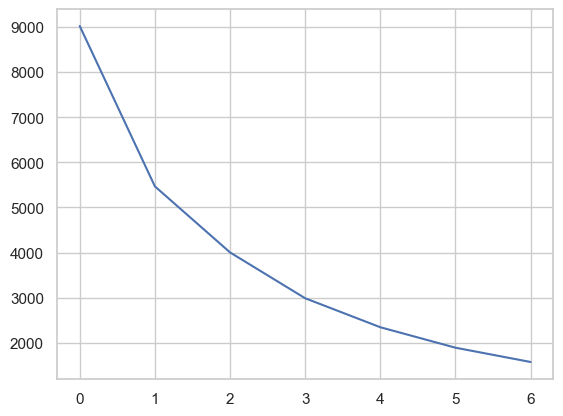

In [289]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_new1)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [290]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_new1)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_new1, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.894840052077457


C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.5882704203144085


C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.6125581611400183


C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.5899810066839075


C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.5800294827694956


C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.5152621490738736


C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.49238540141367915


In [291]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_new1)

C:\Users\Drumil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [319]:
# assign the label
rfm_new['Cluster_Id'] = kmeans.labels_
rfm_new.head()

,recency,frequency,monetary,Cluster_Id
1871,2,248,132458.73,1
323,1,224,28405.56,1
3994,2,169,39869.05,1
1654,2,128,11633.35,1
2168,1,118,59284.19,1


TypeError: Axes3D.scatter() missing 2 required positional arguments: 'xs' and 'ys'

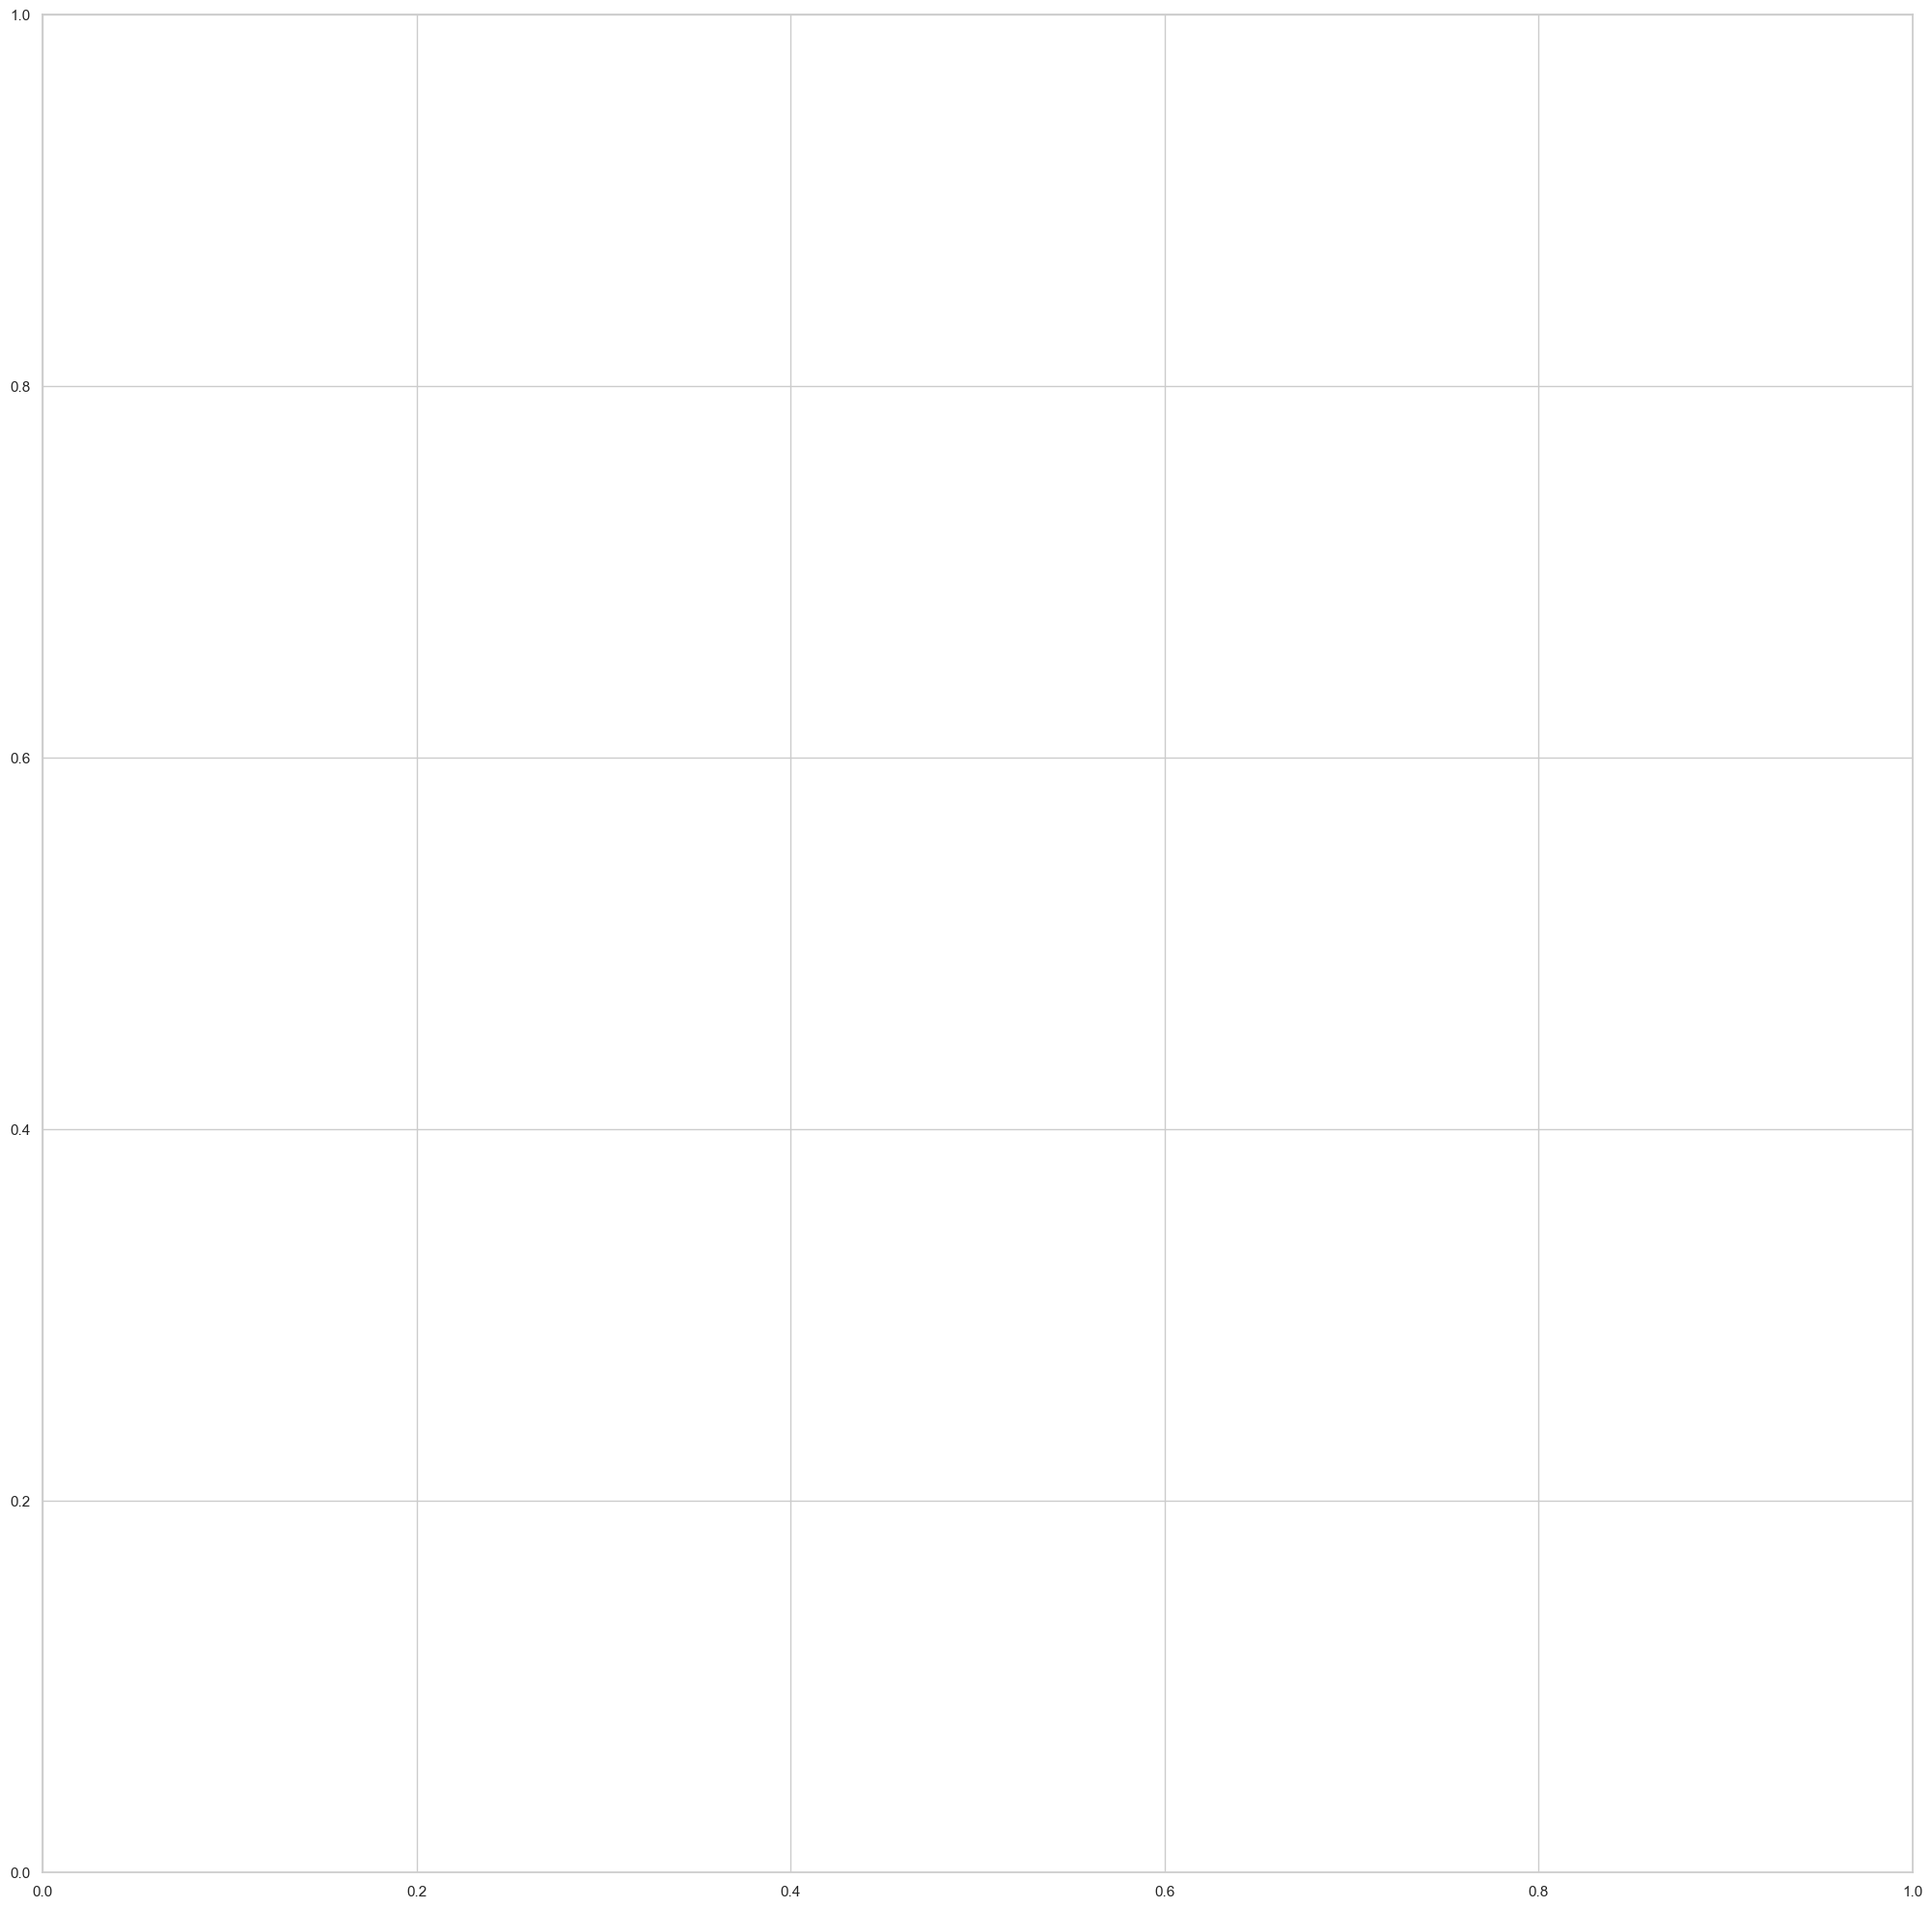

In [321]:
plt.rcParams['figure.figsize']=(25,25)
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig, rect=[0,0,.95,1],
           elev=48,
           azim = 134)
plt.cla()
ax.scatter(rfm_new['frequency'],rfm_new['recency'],rfm_new['monetary'],
          c = rfm_new['Cluster_Id'],
          s = 200,
          cmap='spring',
          alpha = 0.5,
          edgecolor='darkgrey')
ax.set_xlabel('Frequency',fontsize=16)
ax.set_ylabel('Recency',fontsize=16)
ax.set_zlabel('Monetary',fontsize=16)
plt.show()

In [317]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

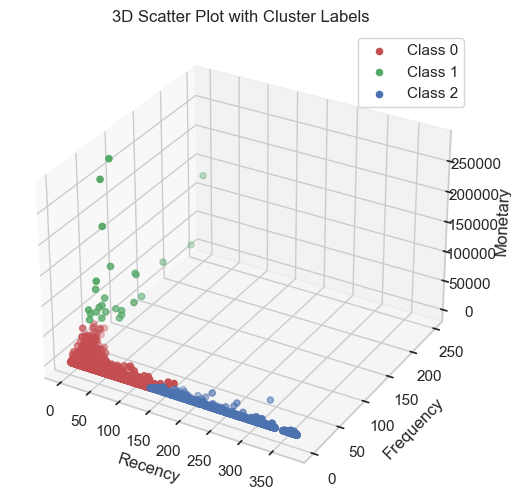

In [322]:
colors = ['r','g','b']
c = [0, 1, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.scatter(rfm_new.loc[rfm_new['Cluster_Id'] == c[i], 'recency'], 
               rfm_new.loc[rfm_new['Cluster_Id'] == c[i], 'frequency'], 
               rfm_new.loc[rfm_new['Cluster_Id'] == c[i], 'monetary'], 
               c=colors[i], 
               label=f'Class {i}')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Scatter Plot with Cluster Labels')
ax.legend()

plt.show()
